# Preprocessing and Feature Engineering

In this notebook, the datasets are preprocessed to make them more efficient and lighter for modeling.

**Content:**
1. Preprocessing - Convert Sex column to numerical
2. Feature Engineering - Create DimentionCluser with kmeans
3. Feature Selection - Drop highly correlated features

#### Import Libraries and Data

In [1]:
# Data exploration and processing
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

#Data Visualisation
import seaborn as sns

In [2]:
train_raw = pd.read_csv('data/playground-series-s4e4/train.csv', index_col = "id")
test_raw = pd.read_csv('data/playground-series-s4e4/test.csv', index_col = "id")

In [3]:
train_raw.head(3)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.240,11
1,F,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.320,11
2,I,0.16,0.11,0.025,0.0210,0.0055,0.0030,0.005,6


In [4]:
test_raw.head(3)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405


In [5]:
# concatenate train and test so we can do the preprocessing to both simultaneously
full_df = pd.concat([train_raw,test_raw], ignore_index=False)
full_df.tail(3)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
151023,I,0.59,0.440,0.155,1.1220,0.3930,0.2000,0.2650,NaN
151024,F,0.66,0.525,0.190,1.4935,0.5885,0.3575,0.4350,NaN
151025,F,0.43,0.340,0.120,0.4150,0.1525,0.0910,0.0905,NaN


#### 1. Preprocessing

##### 1.1 Convert non-numerical columns to numerical

**The Scikit-learn library only accepts numerical values** hence we need to change the Sex column to numerical. 

In [6]:
full_df['Sex'].unique()

array(['F', 'I', 'M'], dtype=object)

"I" stands for infant

In [7]:
# encode sex as new binary columns
full_df = pd.get_dummies(full_df,drop_first=True, dtype=int)

full_df.head(3)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
id,,,,,,,,,,
0,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.240,11.0,0,0
1,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.320,11.0,0,0
2,0.16,0.11,0.025,0.0210,0.0055,0.0030,0.005,6.0,1,0


**Note:** When both Sex_I and Sex_M are 0, then the sex is "F"; the column "F" was eliminated by the drop_first=True argument (any of the three could have eliminated) to reduce the number of columns (i.e., for efficiency)

##### 2. Feature Engineering

##### 2.1 Kmeans Clustering
Given that size features (length, diameter, and height) and weight feature are very correlated to each other, I am creating a cluster that combines one the size features (length) and one of the weight features (Whole Weight)

In [11]:
columns_to_cluster = ["Whole weight", "Length",]

kmeans = KMeans(n_clusters=3, random_state=1111)
full_df["DimensionsCluster"] = kmeans.fit_predict(full_df[columns_to_cluster])
full_df["DimensionsCluster"] = full_df["DimensionsCluster"].astype("category")

<Axes: xlabel='Whole weight', ylabel='Diameter'>

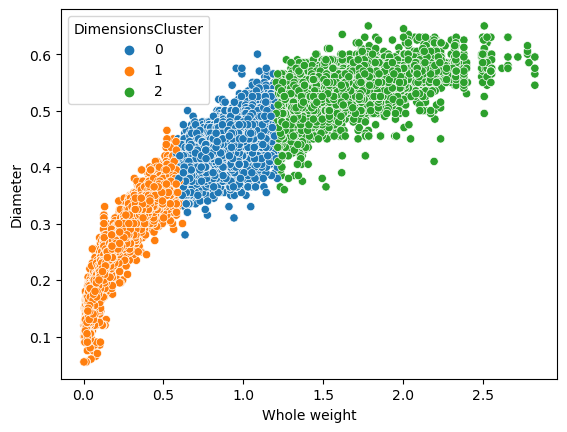

In [9]:
sns.scatterplot(data=full_df, x="Whole weight", y="Diameter", hue="DimensionsCluster")

The three clusters represent abalones with low weight and low length, medium weight and medium length, and large weight and large length 

<Axes: xlabel='DimensionsCluster', ylabel='Rings'>

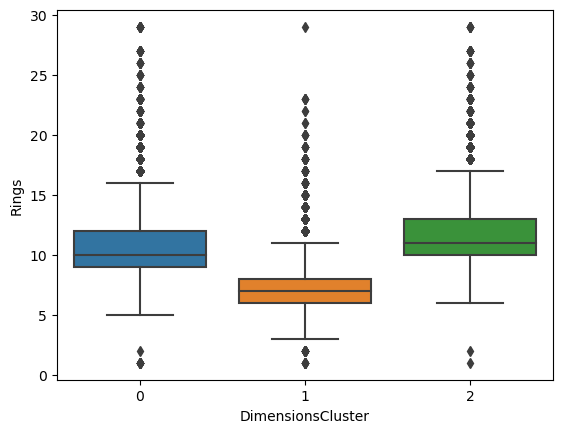

In [10]:
sns.boxplot(data=full_df, x="DimensionsCluster", y="Rings")

cluster 1 contains abalones with the smallest number of rings, followed by cluster 0 and 2

##### 3. Feature Selection

In [14]:
corr = full_df.corr(method='pearson', numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
Length,1.000000,0.989724,0.912872,0.931075,0.909383,0.912992,0.910864,0.623786,-0.655209,0.317215
Diameter,0.989724,1.000000,0.916491,0.933570,0.908280,0.914460,0.917730,0.636832,-0.663618,0.320697
Height,0.912872,0.916491,1.000000,0.899258,0.858838,0.883094,0.901751,0.665772,-0.642057,0.302652
Whole weight,0.931075,0.933570,0.899258,1.000000,0.971124,0.974297,0.963936,0.617274,-0.650513,0.309070
Whole weight.1,0.909383,0.908280,0.858838,0.971124,1.000000,0.949349,0.911469,0.515067,-0.618808,0.301142
Whole weight.2,0.912992,0.914460,0.883094,0.974297,0.949349,1.000000,0.936684,0.588954,-0.645465,0.302762
Shell weight,0.910864,0.917730,0.901751,0.963936,0.911469,0.936684,1.000000,0.694766,-0.647889,0.303091
Rings,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,1.000000,-0.516591,0.240048
Sex_I,-0.655209,-0.663618,-0.642057,-0.650513,-0.618808,-0.645465,-0.647889,-0.516591,1.000000,-0.549508
Sex_M,0.317215,0.320697,0.302652,0.309070,0.301142,0.302762,0.303091,0.240048,-0.549508,1.000000


**The following columns have a very high linear correlation:**
 - Diameter and Lenght > 0.98
 - Whole weight and Whole weight.1 > 0.97
 - Whole weight and Whole weight.2 > 0.97
 - Whole weight and Shell weight > 0.96
 
To make the model selection process more efficient (by makeing the dataset lighter), **I will drop some of the correlated columns below**

In [15]:
full_df.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'Sex_I', 'Sex_M',
       'DimensionsCluster'],
      dtype='object')

In [16]:
# drop and reorder columns
full_df = full_df[['Length', 'Height', 'Whole weight', 'Sex_I', 'Sex_M','DimensionsCluster','Rings']]

##### Recover Train and Test sets

Now that the preprocessing is done, we can recover the train and test sets

In [17]:
full_df.head(3)

,Length,Height,Whole weight,Sex_I,Sex_M,DimensionsCluster,Rings
id,,,,,,,
0,0.55,0.150,0.7715,0,0,0,11.0
1,0.63,0.145,1.1300,0,0,0,11.0
2,0.16,0.025,0.0210,1,0,1,6.0


In [18]:
# recover the processed train sets
train_mod = full_df[full_df.index.isin(train_raw.index)] #_mod stands for modifies
test_mod = full_df[full_df.index.isin(test_raw.index)].dropna(axis = 1)

In [19]:
# change Rings back to integers
train_mod['Rings'] = train_mod['Rings'].astype(int)
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90615 entries, 0 to 90614
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Length             90615 non-null  float64 
 1   Height             90615 non-null  float64 
 2   Whole weight       90615 non-null  float64 
 3   Sex_I              90615 non-null  int32   
 4   Sex_M              90615 non-null  int32   
 5   DimensionsCluster  90615 non-null  category
 6   Rings              90615 non-null  int32   
dtypes: category(1), float64(3), int32(3)
memory usage: 3.9 MB


C:\Users\maico\AppData\Local\Temp\ipykernel_12196\2186041440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod['Rings'] = train_mod['Rings'].astype(int)


In [20]:
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60411 entries, 90615 to 151025
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Length             60411 non-null  float64 
 1   Height             60411 non-null  float64 
 2   Whole weight       60411 non-null  float64 
 3   Sex_I              60411 non-null  int32   
 4   Sex_M              60411 non-null  int32   
 5   DimensionsCluster  60411 non-null  category
dtypes: category(1), float64(3), int32(2)
memory usage: 2.4 MB


In [21]:
train_mod.to_csv('data/train_preprocessed.csv')
test_mod.to_csv('data/test_preprocessed.csv')